In [1]:
# visualization and database management
import h5py
import os
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os
from sklearn.utils import shuffle
from mlxtend.plotting import plot_decision_regions

# Machine learning
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#auto load external code.
%load_ext autoreload  
%autoreload 2

/Users/trongnguyen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# set large font for presentation
sns.set_context("poster", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20}) 
import matplotlib 
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
sns.set_style('darkgrid')

In [3]:
os.chdir('/Users/trongnguyen/Dropbox/FattyLiver/src/hydrogen/')
from helper_brl.visualizeHelper import extract_segment_points, envDetection, filter_frame
from helper_brl.fattyLiver import get_training_data, get_testing_data, choose_testing_rabbits_indices
from helper_brl.outlierDetection import getBSC_Att, filter_bsc, filter_BSC_based_on_depth, findOutliers
from helper_brl import frequencyAnalysis
from helper_brl.formFactor import get_ESD_EAC, gaussian_form_factor_bsc, exponential_form_factor_bsc, ESD_EAC_features
from helper_brl.ml_preprocessing import percentageVariance, cal_accuracy, randomize_and_filter

# Load Data

In [5]:
newdataBase = pd.read_excel('/Users/trongnguyen/Dropbox/FattyLiver/Rabbit_Liver_40.xlsx', sheet_name=0)
aliveOnly = newdataBase[newdataBase['Timely death'] == 1]
dataBase = aliveOnly[['Rabbit', 'Injection level', 'Weeks on diet','Lipid']]
dataBase = dataBase[dataBase['Injection level'] ==0]

threshold_lipid = 9
dataBase['High'] = dataBase.Lipid > threshold_lipid
dataBase = dataBase.sort_values(['Lipid'])
dataBase.index = range(1, 16)
dataBase['Labels'] = dataBase['High'].apply(lambda x: 'High lipid' if x else 'Low lipid')

In [6]:
dataBase[dataBase.Lipid > threshold_lipid]['Lipid'].describe()

count     8.000000
mean     14.021250
std       3.250316
min       9.810000
25%      12.607500
50%      13.920000
75%      14.712500
max      20.660000
Name: Lipid, dtype: float64

In [7]:
dataBase[dataBase.Lipid <= threshold_lipid]['Lipid'].describe()

count    7.000000
mean     5.740000
std      2.116294
min      3.270000
25%      3.695000
50%      6.600000
75%      7.360000
max      8.200000
Name: Lipid, dtype: float64

In [8]:
%qtconsole

In [8]:
dataBase['Rabbit ID'] = np.arange(1,16)

In [9]:
dataBase['Labels'] = dataBase['High'].apply(lambda x: 'High fat' if x else 'Low fat')

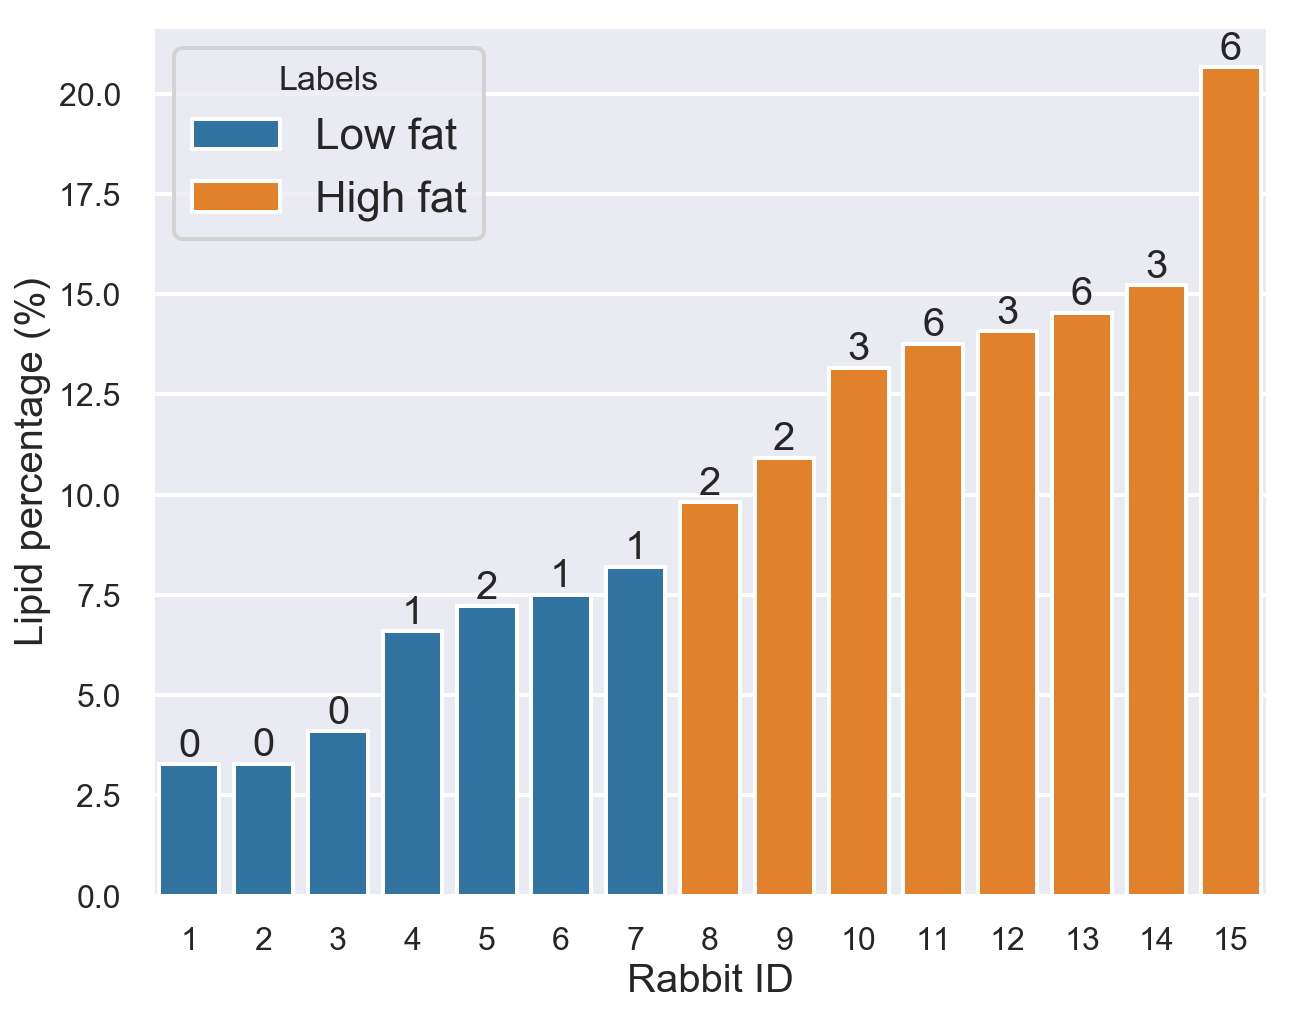

In [12]:
plt.figure(figsize = (10, 8))
ax = sns.barplot(x = 'Rabbit ID', y = 'Lipid', data = dataBase, hue = 'Labels', \
                 order=dataBase['Rabbit ID'], dodge = False)
count = 1
ax.set_ylabel('Lipid percentage (%)')
for p in ax.patches:
    height = p.get_height()
    if np.isnan(height):
        continue
    no_weeks = dataBase['Weeks on diet'][count]
    count = count + 1
    plt.text(p.get_x()+p.get_width()/2.,
            height + 0.2,
            no_weeks,
            ha="center") 

## Input/output data  - Load BSC and ATT

In [9]:
#RIGHT_SIDE = ['750', '754', '753']
#RIGHT_SIDE = ['750', '730']
RIGHT_SIDE = ['754', '751', '729']

In [10]:
ATTs_dict, freq_att_dict, freq_bsc_dict, depth_dict, BSCs_dict = {}, {}, {}, {}, {} 
left_dict, right_dict, top_dict, bottom_dict = {}, {}, {}, {} # ROIs of each BSC
att_bottom, bad_BSC = {}, {}

#name_tag = 'fix_bug_average_ref_phantom_6MHz_v7_12a_30b'
name_tag = 'fix_bug_average_ref_phantom_3_6MHz_v8_10a40_30b'
for idx, row in dataBase.iterrows():
    number = str(int(row.Rabbit))
    print(number, end = ', ')
    if number in RIGHT_SIDE:
        path = "/Volumes/TrongDrive/Liver_Study/PostProcessedFiles/L" + number + "/L94_right/BSC_ATT/"
    else:
        path = "/Volumes/TrongDrive/Liver_Study/PostProcessedFiles/L" + number + "/L94_left/BSC_ATT/"
    ATTs_dict[number], freq_att_dict[number], BSCs_dict[number], freq_bsc_dict[number], \
    depth_dict[number], left_dict[number], right_dict[number], \
    top_dict[number], bottom_dict[number], att_bottom[number], bad_BSC[number] = getBSC_Att(path,name_tag)

729, 749, 750, 752, 730, 739, 751, 754, 753, 740, 731, 755, 757, 756, 758, 

In [11]:
rf_hdf5_path = '/Volumes/TrongDrive/Liver_Study/RF_hdf5/'
root_path = '/Volumes/TrongDrive/Liver_Study/PostProcessedFiles/L'

# PCA and Random Forest and CNN stuff

In [12]:
all_idx = dataBase.Rabbit.as_matrix()
no_cv = 15

In [13]:
freq_key = next(iter(freq_bsc_dict['729']))
freq = freq_bsc_dict['729'][freq_key].flatten()
print(freq)

[ 3.          3.00293255  3.0058651  ...,  5.9941349   5.99706745  6.        ]


## Compare PCA vs ESD_EAC_linear fit

[729]
Skip,749,750,752,730,739,751,754,753,740,731,755,757,756,758,729,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 
 Frame break: 125 125
Training and testing shape (2927, 1024) (125, 1024)
Labels shape: (2927,) (125,)
Explained variance 0.968307960614
(125, 2) (2927, 2)
Linear ROI testing accuracy: 0.0
PCA ROI testing accuracy: 0.0
Linear ROI Training accuracy: 0.846600614964
PCA ROI Training accuracy: 0.845575674752
PCA Frame accuracy 0.0
Linear frame accuracy 0.0


/Users/trongnguyen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in true_divide


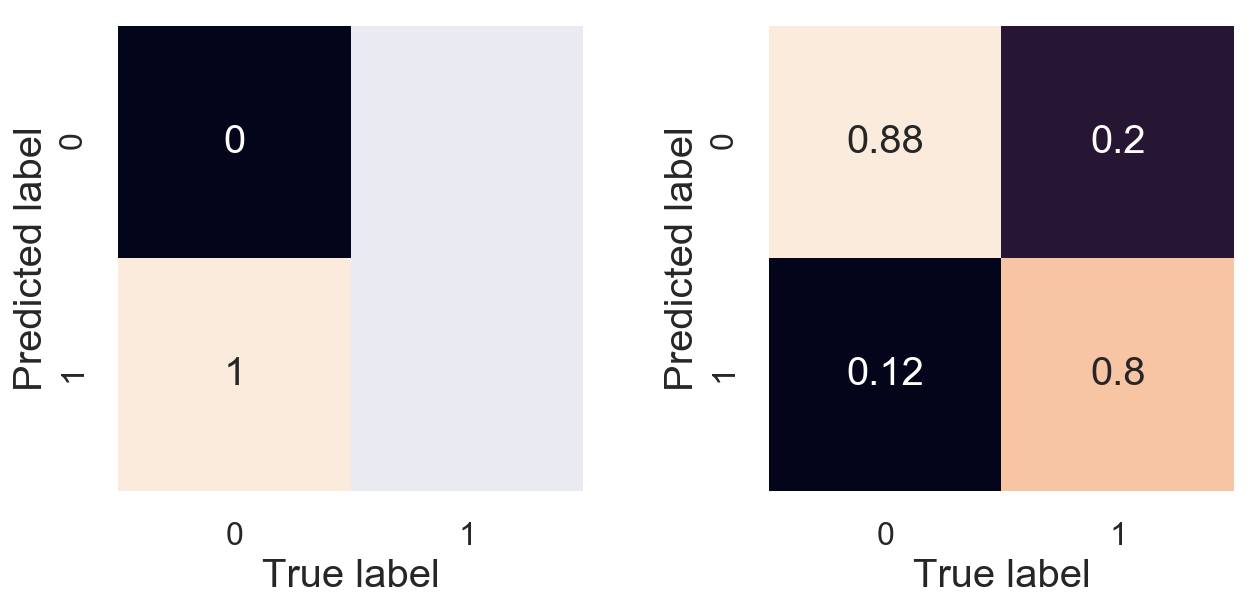

[749]
729,Skip,750,752,730,739,751,754,753,740,731,755,757,756,758,Skip, 749,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 
 Frame break: 391 390
Training and testing shape (2662, 1024) (390, 1024)
Labels shape: (2662,) (390,)
Explained variance 0.96813313443
(390, 2) (2662, 2)
Linear ROI testing accuracy: 0.966666666667
PCA ROI testing accuracy: 0.958974358974
Linear ROI Training accuracy: 0.78362133734
PCA ROI Training accuracy: 0.792261457551
PCA Frame accuracy 1.0
Linear frame accuracy 1.0


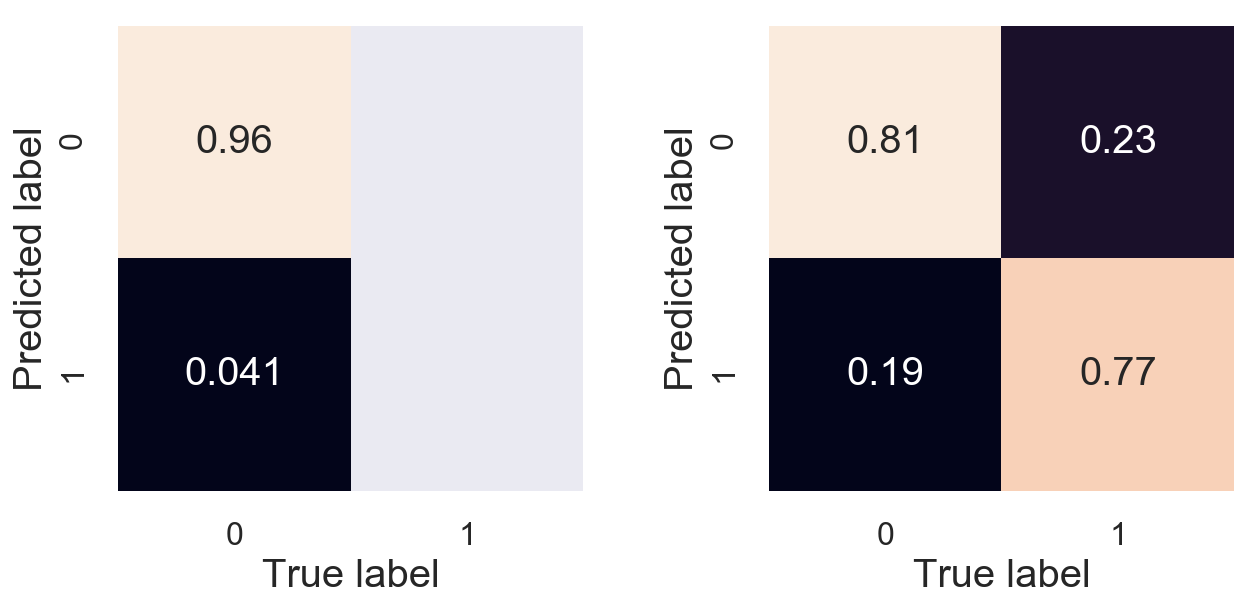

[750]
729,749,Skip,752,730,739,751,754,753,740,731,755,757,756,758,Skip, Skip, 750,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 
 Frame break: 37 37
Training and testing shape (3015, 1024) (37, 1024)
Labels shape: (3015,) (37,)
Explained variance 0.966000173666
(37, 2) (3015, 2)
Linear ROI testing accuracy: 1.0
PCA ROI testing accuracy: 1.0
Linear ROI Training accuracy: 0.803316749585
PCA ROI Training accuracy: 0.805970149254
PCA Frame accuracy 1.0
Linear frame accuracy 1.0


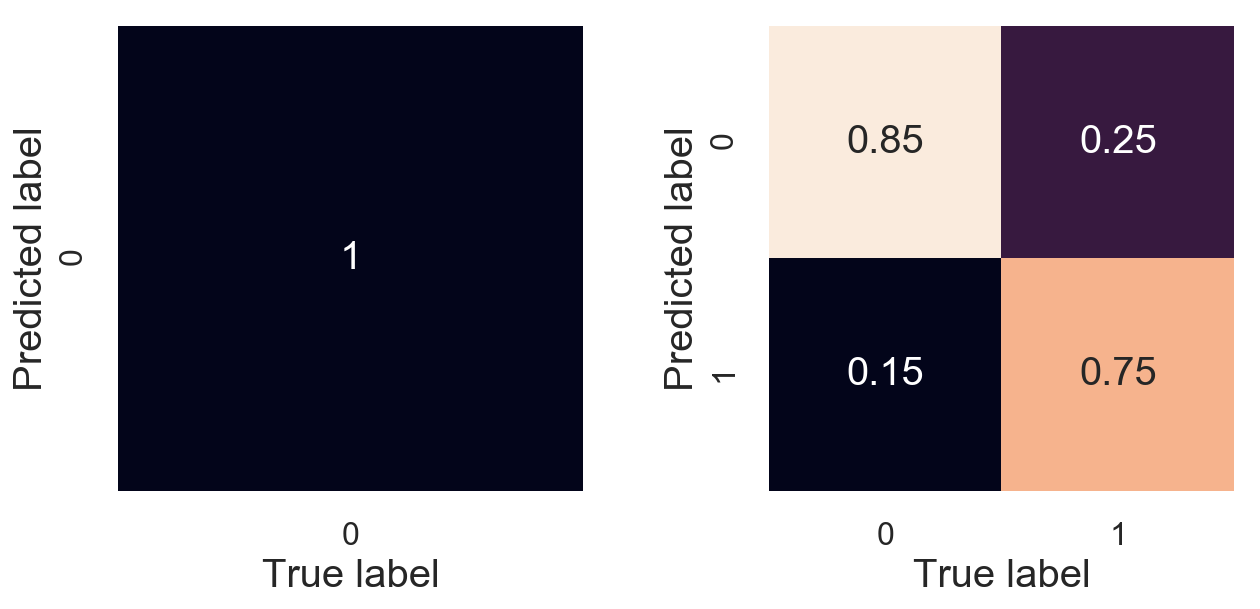

[752]
729,749,750,Skip,730,739,751,754,753,740,731,755,757,756,758,Skip, Skip, Skip, 752,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 
 Frame break: 247 247
Training and testing shape (2805, 1024) (247, 1024)
Labels shape: (2805,) (247,)
Explained variance 0.969753945652
(247, 2) (2805, 2)
Linear ROI testing accuracy: 0.882591093117
PCA ROI testing accuracy: 0.757085020243
Linear ROI Training accuracy: 0.806060606061
PCA ROI Training accuracy: 0.816042780749
PCA Frame accuracy 0.875
Linear frame accuracy 0.979166666667


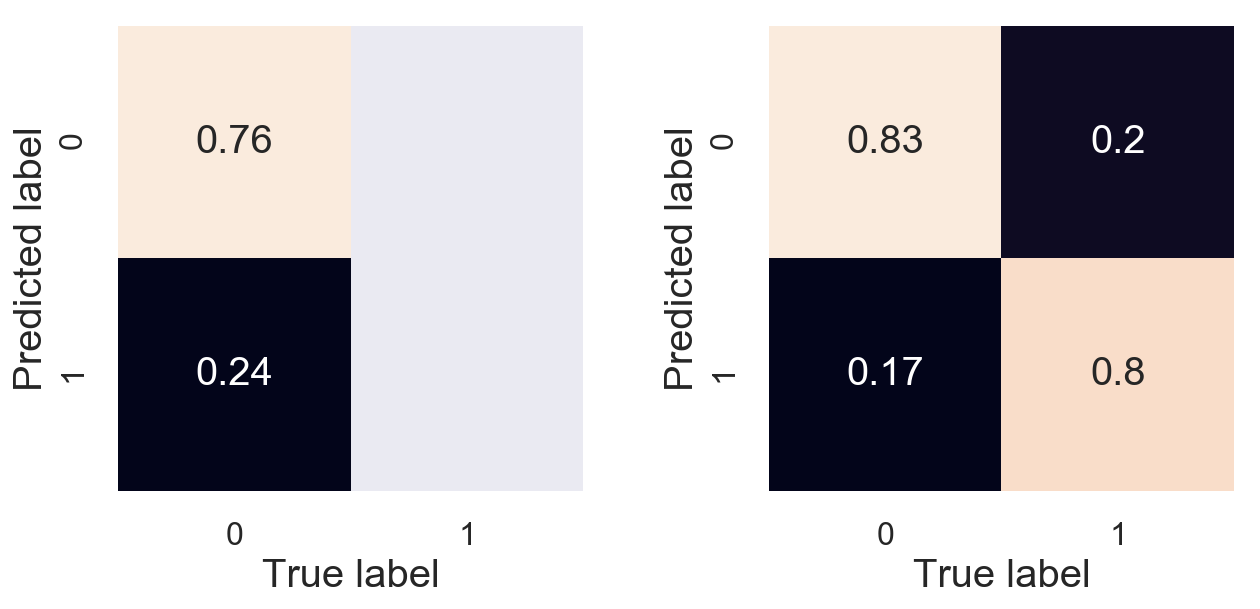

[730]
729,749,750,752,Skip,739,751,754,753,740,731,755,757,756,758,Skip, Skip, Skip, Skip, 730,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 
 Frame break: 140 134
Training and testing shape (2918, 1024) (134, 1024)
Labels shape: (2918,) (134,)
Explained variance 0.964314249171
(134, 2) (2918, 2)
Linear ROI testing accuracy: 1.0
PCA ROI testing accuracy: 1.0
Linear ROI Training accuracy: 0.79677861549
PCA ROI Training accuracy: 0.800548320768
PCA Frame accuracy 1.0
Linear frame accuracy 1.0


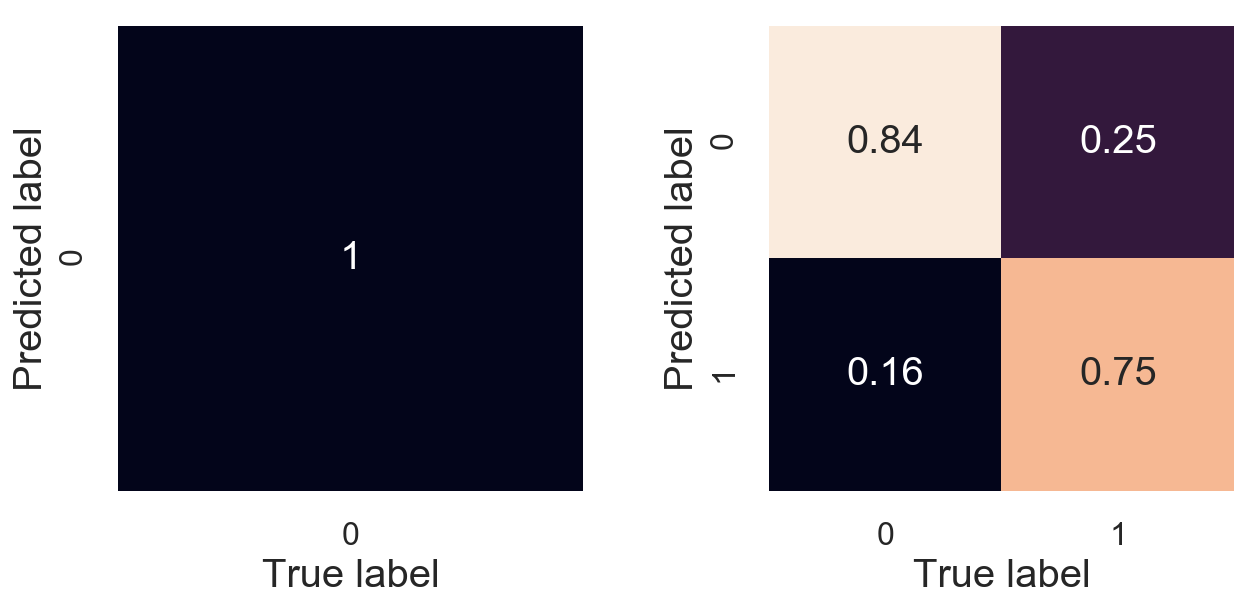

[739]
729,749,750,752,730,Skip,751,754,753,740,731,755,757,756,758,Skip, Skip, Skip, Skip, Skip, 739,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 
 Frame break: 699 699
Training and testing shape (2353, 1024) (699, 1024)
Labels shape: (2353,) (699,)
Explained variance 0.972813584432
(699, 2) (2353, 2)
Linear ROI testing accuracy: 0.894134477825
PCA ROI testing accuracy: 0.832618025751
Linear ROI Training accuracy: 0.781555461113
PCA ROI Training accuracy: 0.79175520612
PCA Frame accuracy 0.897959183673
Linear frame accuracy 0.938775510204


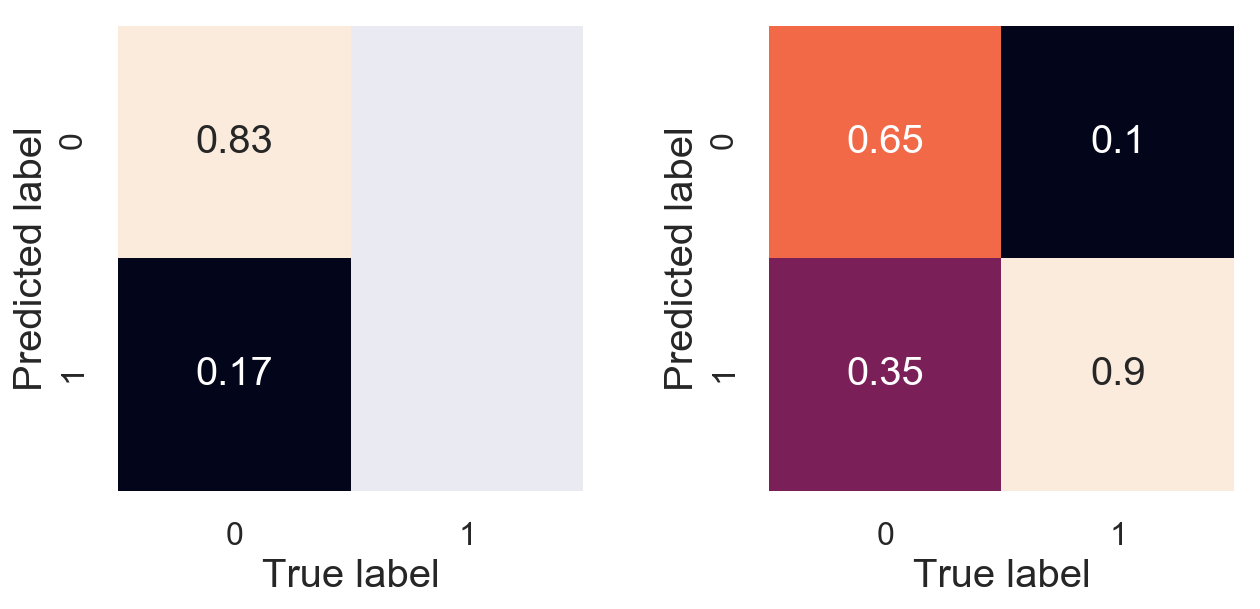

[751]
729,749,750,752,730,739,Skip,754,753,740,731,755,757,756,758,Skip, Skip, Skip, Skip, Skip, Skip, 751,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 
 Frame break: 66 66
Training and testing shape (2986, 1024) (66, 1024)
Labels shape: (2986,) (66,)
Explained variance 0.967328666623
(66, 2) (2986, 2)
Linear ROI testing accuracy: 0.0151515151515
PCA ROI testing accuracy: 0.0151515151515
Linear ROI Training accuracy: 0.826523777629
PCA ROI Training accuracy: 0.828868050904
PCA Frame accuracy 0.0
Linear frame accuracy 0.0


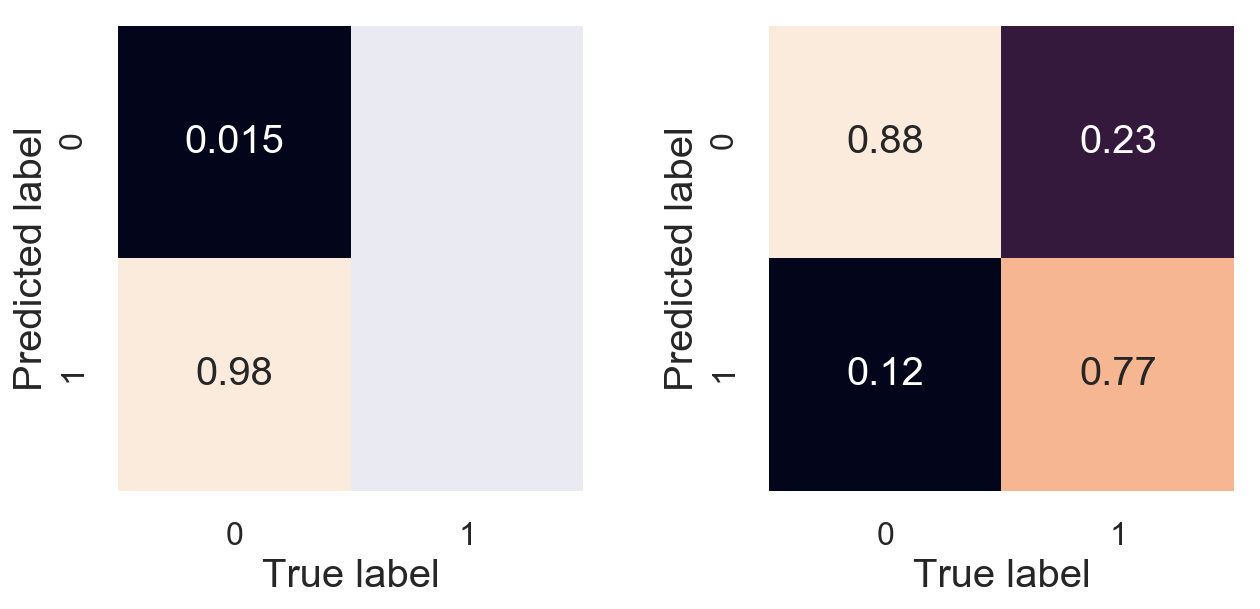

[754]
729,749,750,752,730,739,751,Skip,753,740,731,755,757,756,758,Skip, Skip, Skip, Skip, Skip, Skip, Skip, 754,Skip, Skip, Skip, Skip, Skip, Skip, Skip, 
 Frame break: 58 58
Training and testing shape (2994, 1024) (58, 1024)
Labels shape: (2994,) (58,)
Explained variance 0.967751864587
(58, 2) (2994, 2)
Linear ROI testing accuracy: 1.0
PCA ROI testing accuracy: 1.0
Linear ROI Training accuracy: 0.801937207749
PCA ROI Training accuracy: 0.803607214429
PCA Frame accuracy 1.0
Linear frame accuracy 1.0


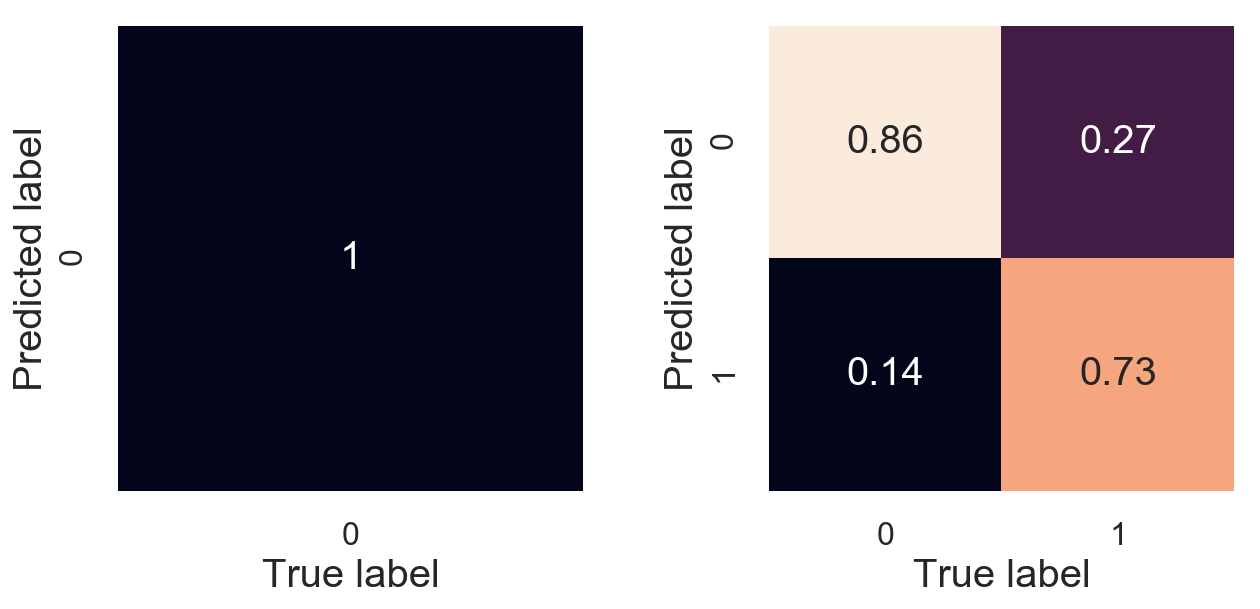

[753]
729,749,750,752,730,739,751,754,Skip,740,731,755,757,756,758,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 753,Skip, Skip, Skip, Skip, Skip, Skip, 
 Frame break: 170 170
Training and testing shape (2882, 1024) (170, 1024)
Labels shape: (2882,) (170,)
Explained variance 0.968165519146
(170, 2) (2882, 2)
Linear ROI testing accuracy: 0.0470588235294
PCA ROI testing accuracy: 0.0941176470588
Linear ROI Training accuracy: 0.839347675226
PCA ROI Training accuracy: 0.84212352533
PCA Frame accuracy 0.0540540540541
Linear frame accuracy 0.0540540540541


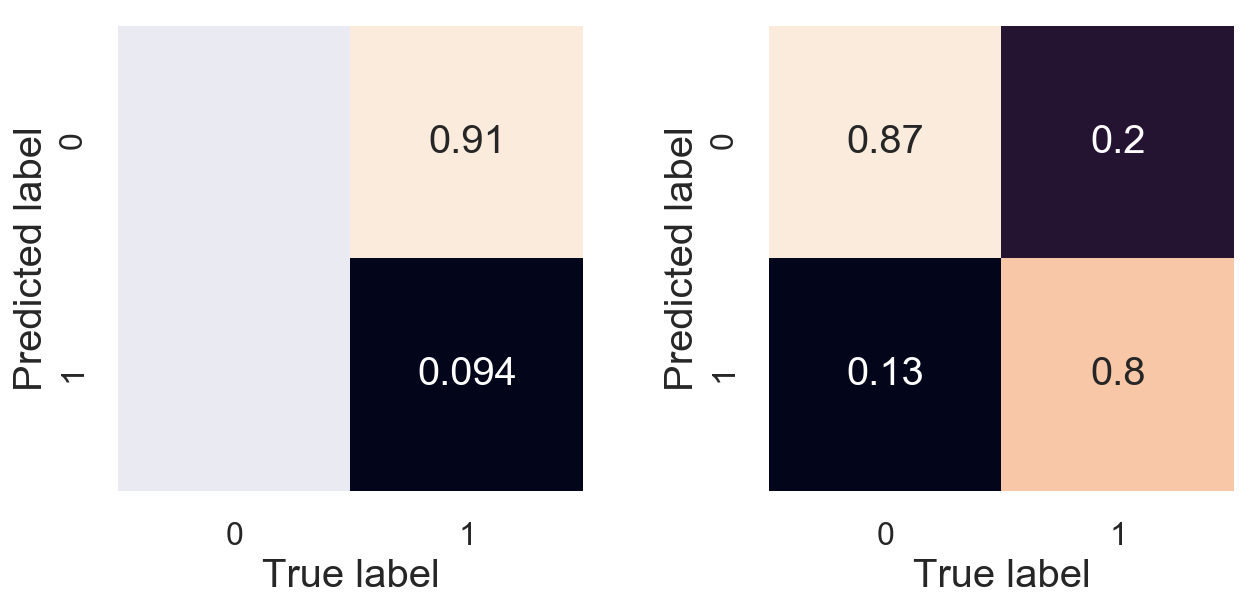

[740]
729,749,750,752,730,739,751,754,753,Skip,731,755,757,756,758,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 740,Skip, Skip, Skip, Skip, Skip, 
 Frame break: 87 87
Training and testing shape (2965, 1024) (87, 1024)
Labels shape: (2965,) (87,)
Explained variance 0.967926784572
(87, 2) (2965, 2)
Linear ROI testing accuracy: 0.988505747126
PCA ROI testing accuracy: 0.988505747126
Linear ROI Training accuracy: 0.798988195616
PCA ROI Training accuracy: 0.797976391231
PCA Frame accuracy 1.0
Linear frame accuracy 1.0


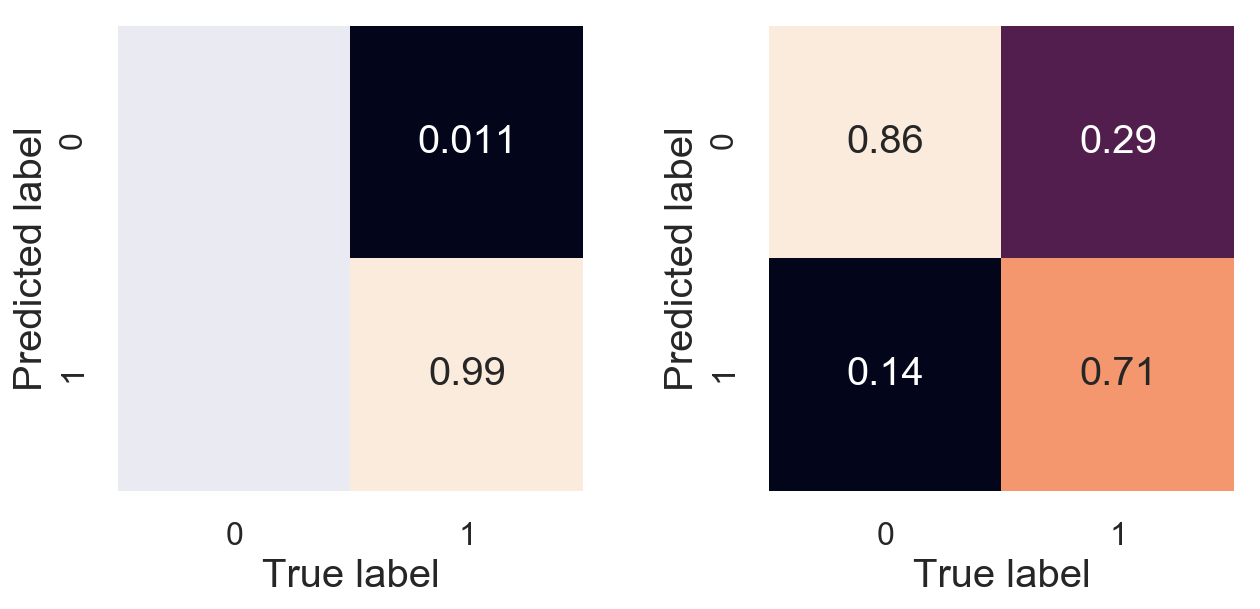

[731]
729,749,750,752,730,739,751,754,753,740,Skip,755,757,756,758,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 731,Skip, Skip, Skip, Skip, 
 Frame break: 138 138
Training and testing shape (2914, 1024) (138, 1024)
Labels shape: (2914,) (138,)
Explained variance 0.968235885687
(138, 2) (2914, 2)
Linear ROI testing accuracy: 0.608695652174
PCA ROI testing accuracy: 0.666666666667
Linear ROI Training accuracy: 0.805078929307
PCA ROI Training accuracy: 0.810569663693
PCA Frame accuracy 0.853658536585
Linear frame accuracy 0.780487804878


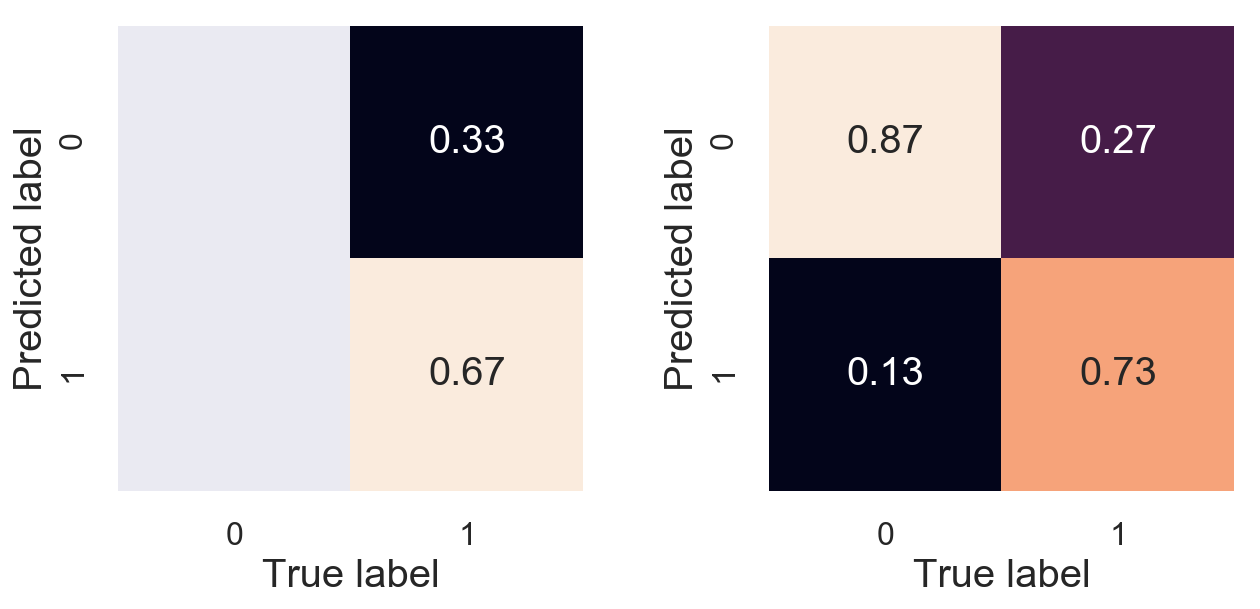

[755]
729,749,750,752,730,739,751,754,753,740,731,Skip,757,756,758,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 755,Skip, Skip, Skip, 
 Frame break: 206 206
Training and testing shape (2846, 1024) (206, 1024)
Labels shape: (2846,) (206,)
Explained variance 0.968736137873
(206, 2) (2846, 2)
Linear ROI testing accuracy: 0.0582524271845
PCA ROI testing accuracy: 0.121359223301
Linear ROI Training accuracy: 0.845045678145
PCA ROI Training accuracy: 0.848208011244
PCA Frame accuracy 0.0816326530612
Linear frame accuracy 0.0408163265306


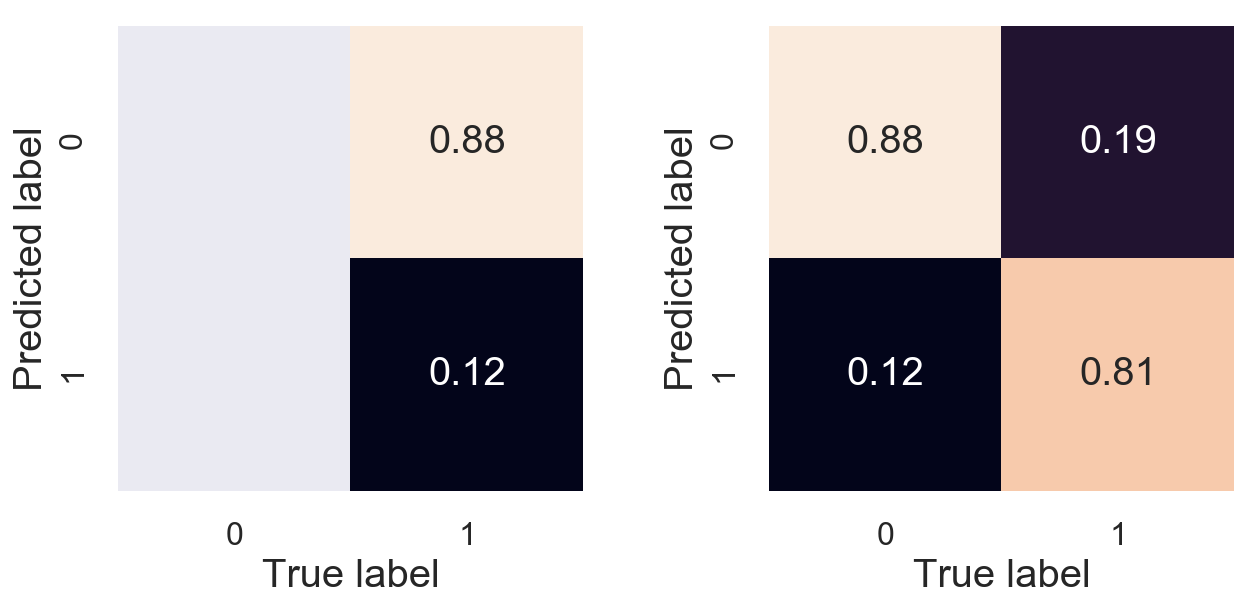

[757]
729,749,750,752,730,739,751,754,753,740,731,755,Skip,756,758,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 757,Skip, Skip, 
 Frame break: 104 104
Training and testing shape (2948, 1024) (104, 1024)
Labels shape: (2948,) (104,)
Explained variance 0.967921681721
(104, 2) (2948, 2)
Linear ROI testing accuracy: 1.0
PCA ROI testing accuracy: 1.0
Linear ROI Training accuracy: 0.798846675712
PCA ROI Training accuracy: 0.801221166893
PCA Frame accuracy 1.0
Linear frame accuracy 1.0


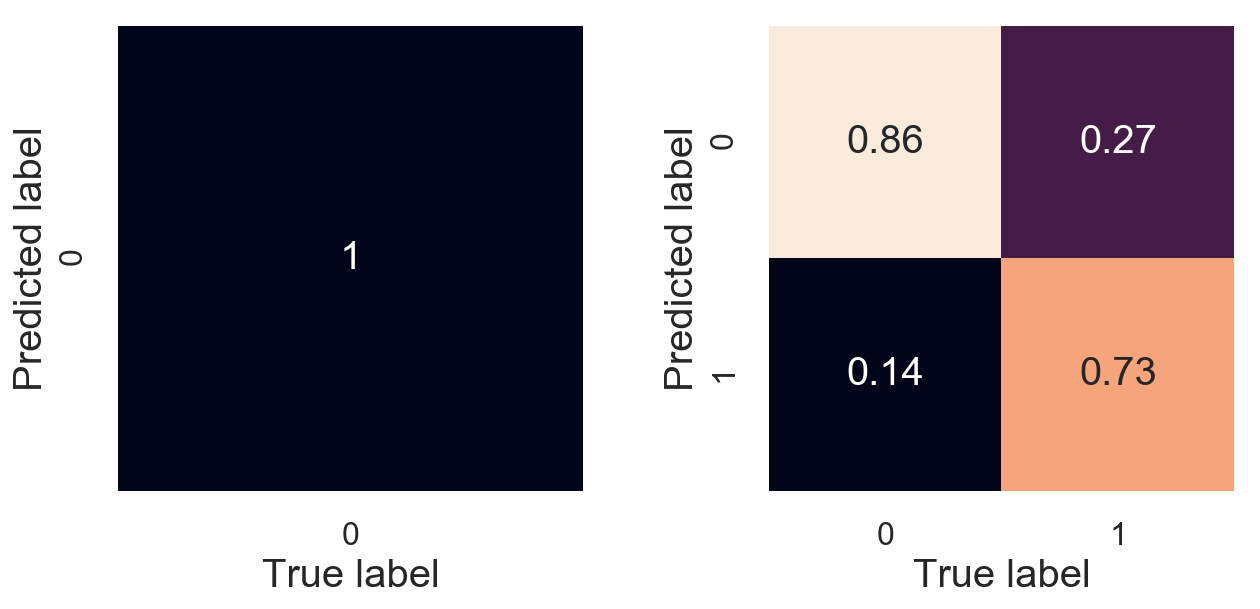

[756]
729,749,750,752,730,739,751,754,753,740,731,755,757,Skip,758,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 756,Skip, 
 Frame break: 41 41
Training and testing shape (3011, 1024) (41, 1024)
Labels shape: (3011,) (41,)
Explained variance 0.967633886446
(41, 2) (3011, 2)
Linear ROI testing accuracy: 0.682926829268
PCA ROI testing accuracy: 0.951219512195
Linear ROI Training accuracy: 0.802059116573
PCA ROI Training accuracy: 0.803719694454
PCA Frame accuracy 0.96
Linear frame accuracy 0.84


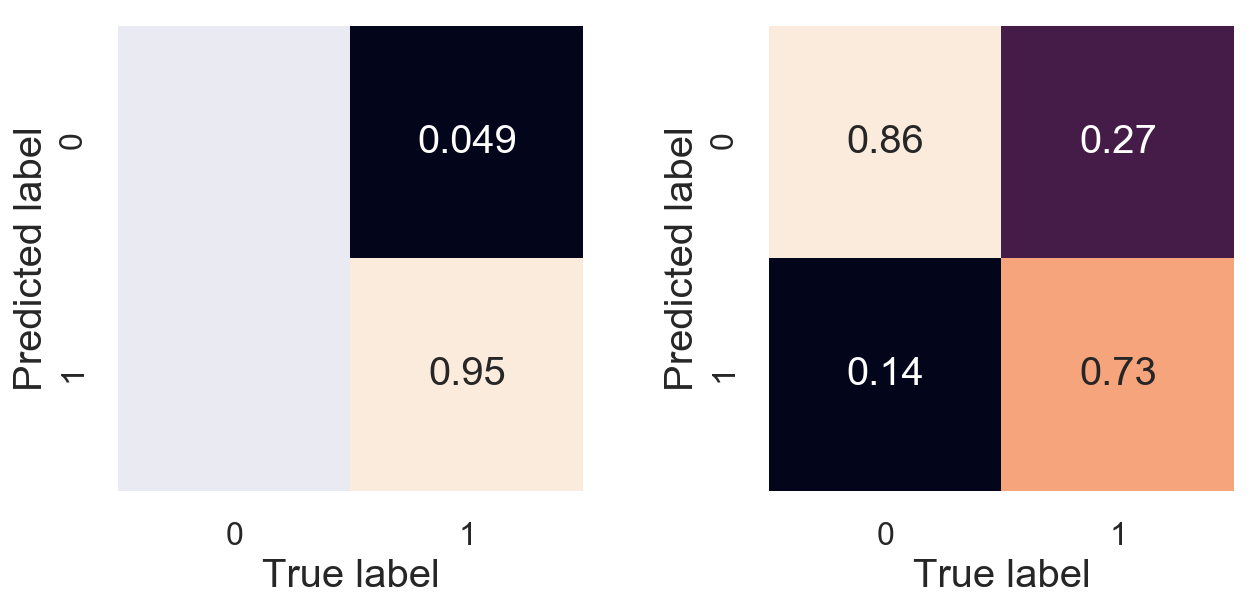

[758]
729,749,750,752,730,739,751,754,753,740,731,755,757,756,Skip,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 758,
 Frame break: 550 550
Training and testing shape (2502, 1024) (550, 1024)
Labels shape: (2502,) (550,)
Explained variance 0.928127417263
(550, 2) (2502, 2)
Linear ROI testing accuracy: 0.0
PCA ROI testing accuracy: 0.0
Linear ROI Training accuracy: 0.814948041567
PCA ROI Training accuracy: 0.818944844125
PCA Frame accuracy 0.0
Linear frame accuracy 0.0


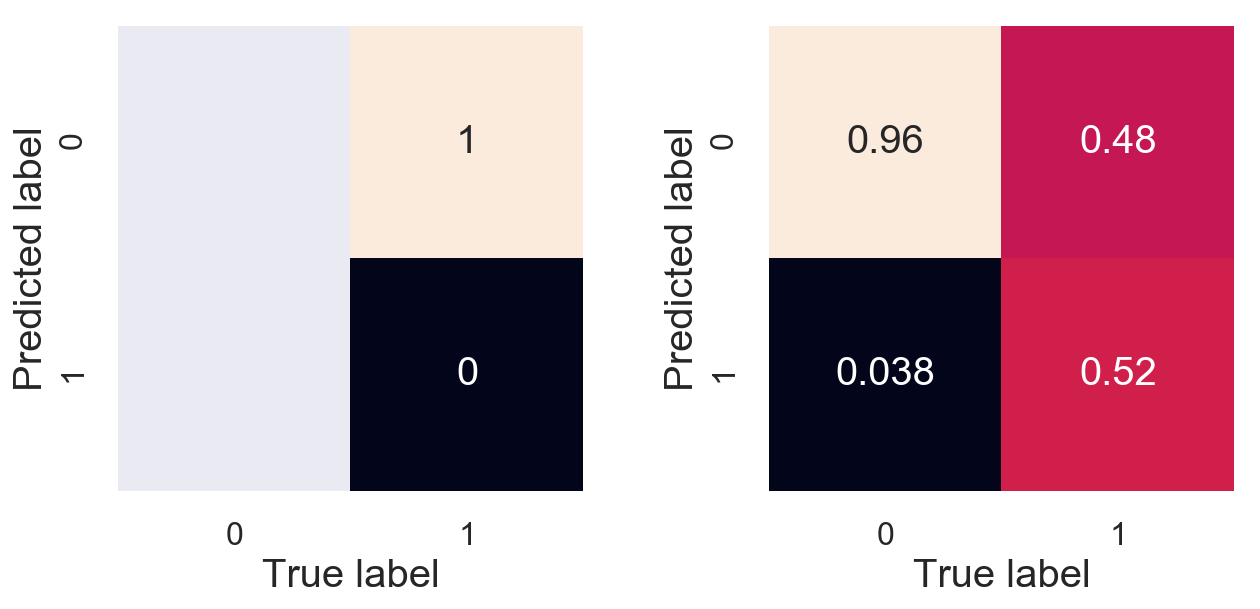

In [18]:
no_components = 2
#no_test_rabbits = no_testing * 2
accuracy_frame_comparison = np.zeros((no_cv, 4))
accuracy_roi_comparison = np.zeros((no_cv, 4))
for i in range(no_cv):
    #testing_idx = all_idx[i*no_test_rabbits:i*no_test_rabbits+no_test_rabbits]
    testing_idx = [all_idx[i]]
    print(testing_idx)
    X_train, y_train = get_training_data(dataBase, testing_idx, BSCs_dict, freq_bsc_dict, depth_dict,True)
    X_test, y_test, frame_idx, frame_break = get_testing_data(dataBase, testing_idx, BSCs_dict, freq_bsc_dict, depth_dict, True)
    
    X_train, y_train, X_test, y_test, idxs1, idxs2 = randomize_and_filter(X_train, y_train, \
                                                                          X_test, y_test)   
 
    flat_list = [item for sublist in frame_idx for item in sublist]
    frame_idx1 = np.array(flat_list) 
    frame_idx = frame_idx1[idxs2]
    
    print("\n Frame break: ", end = '')
    print(np.sum(np.array(frame_break)), len(frame_idx))
    
    print("Training and testing shape", X_train.shape, X_test.shape)
    print('Labels shape', end = ': ')
    print(y_train.shape, y_test.shape)
    
    pca1 = PCA() ## PCA in the log10 of the BSCs.
    pca1.fit(np.log10(X_train))
    print("Explained variance", percentageVariance(pca1.explained_variance_, no_components))
    
    pca = PCA(n_components=no_components) ## PCA in the log10 of the BSCs.
    pca.fit(np.log10(X_train))
    features_train  = pca.transform(np.log10(X_train))
    features_test  = pca.transform(np.log10(X_test))
    print(features_test.shape, features_train.shape)
    
    #clf = svm.SVC(C=10.0, kernel='rbf', gamma=0.1) #{'C': 10, 'gamma': 0.1}
    #clf_linear = svm.SVC(C=10.0, kernel='rbf', gamma=0.1)
    clf = svm.SVC(C=1.0, kernel='linear', gamma=0.1) #{'C': 10, 'gamma': 0.1}
    clf_linear = svm.SVC(C=1.0, kernel='linear', gamma=0.1)
    
    linear_train = ESD_EAC_features(freq, X_train)
    linear_test = ESD_EAC_features(freq, X_test) 
    
    #clf = RandomForestClassifier(n_estimators=1000)
    clf.fit(features_train, y_train)
    clf_linear.fit(linear_train, y_train)
    
    y_predict_linear = clf_linear.predict(linear_test)
    y_predict_pca = clf.predict(features_test)
    y_train_predict_pca = clf.predict(features_train)
    
    accuracy_roi_comparison[i, 0] = accuracy_score(y_test, y_predict_linear)
    print('Linear ROI testing accuracy:', accuracy_roi_comparison[i, 0])
    
    accuracy_roi_comparison[i, 1] = accuracy_score(y_test, y_predict_pca)
    print('PCA ROI testing accuracy:', accuracy_roi_comparison[i, 1])
    
    accuracy_roi_comparison[i, 2] = accuracy_score(y_train, clf_linear.predict(linear_train))
    print('Linear ROI Training accuracy:', accuracy_roi_comparison[i, 2])
    
    accuracy_roi_comparison[i, 3] = accuracy_score(y_train, y_train_predict_pca)
    print('PCA ROI Training accuracy:', accuracy_roi_comparison[i, 3])
    
    frame_accuracy = cal_accuracy(y_test, y_predict_pca, np.append(frame_idx, '0'))
    accuracy_frame_comparison[i, 1] = np.sum(frame_accuracy)/len(frame_accuracy)
    print('PCA Frame accuracy', accuracy_frame_comparison[i, 1])
    
    frame_accuracy = cal_accuracy(y_test, y_predict_linear, np.append(frame_idx, '0'))
    accuracy_frame_comparison[i, 0] = np.sum(frame_accuracy)/len(frame_accuracy)
    print('Linear frame accuracy', accuracy_frame_comparison[i, 0] )
    
    plt.figure(figsize = (10, 8))
    plt.subplots_adjust(wspace = 0.4)
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_test, y_predict_pca) # generate the confusion matrix
    n_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the accuracy
    #print(classification_report(y_test, y_predict_pca))
    sns.heatmap(n_cm.T, square=True, annot=True, cbar=False)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')

    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_train, y_train_predict_pca) # generate the confusion matrix
    n_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the accuracy
    sns.heatmap(n_cm.T, square=True, annot=True, cbar=False)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.show()
    #print(classification_report(y_train, y_train_predict ))

In [14]:
no_components = 2

testing_idx = [752]
X_train, y_train = get_training_data(dataBase, testing_idx, BSCs_dict, freq_bsc_dict, depth_dict,True)
X_test, y_test, frame_idx, frame_break = get_testing_data(dataBase, testing_idx, BSCs_dict, freq_bsc_dict, depth_dict, True)

X_train, y_train, X_test, y_test, idxs1, idxs2 = randomize_and_filter(X_train, y_train, \
                                                                      X_test, y_test)   
print("Training and testing shape", X_train.shape, X_test.shape)
print('Labels shape', end = ': ')
print(y_train.shape, y_test.shape)

pca = PCA(n_components=no_components) ## PCA in the log10 of the BSCs.
pca.fit(np.log10(X_train))
#features_train  = pca.transform(np.log10(X_train))
#features_test  = pca.transform(np.log10(X_test))

features_train = ESD_EAC_features(freq, X_train)
features_test = ESD_EAC_features(freq, X_test) 
    
print(features_test.shape, features_train.shape)

clf = svm.SVC(C=1.0, kernel='linear', gamma=1) #{'C': 10, 'gamma': 0.1}
clf.fit(features_train, y_train)

y_predict_pca = clf.predict(features_test)
y_train_predict_pca = clf.predict(features_train)

print('PCA ROI testing accuracy:', accuracy_score(y_test, y_predict_pca))
print('PCA ROI train accuracy:', accuracy_score(y_train, y_train_predict_pca))

l1 = np.where(y_train == 0)[0]
l2 = np.where(y_train == 1)[0]
l3 = np.where(y_predict_pca == 0) [0]
l4 = np.where(y_predict_pca == 1) [0]
#plt.figure(figsize = (12, 10))
#plt.scatter(features_train[l1, 0], features_train[l1, 1], c = 'b', s = 2)
#plt.scatter(features_train[l2, 0], features_train[l2, 1], c = 'r', s = 2)
#plt.scatter(features_test[l3, 0], features_test[l3, 1], c = 'cyan', s = 2)
#plt.scatter(features_test[l4, 0], features_test[l4, 1], c = 'fuchsia', s = 2)
#plot_decision_regions(features_train, y_train, clf = clf)
#plt.title(str(testing_idx[0]))
#plt.show()

729,749,750,Skip,730,739,751,754,753,740,731,755,757,756,758,Skip, Skip, Skip, 752,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Training and testing shape (2805, 1024) (247, 1024)
Labels shape: (2805,) (247,)
(247, 2) (2805, 2)
PCA ROI testing accuracy: 0.882591093117
PCA ROI train accuracy: 0.806060606061


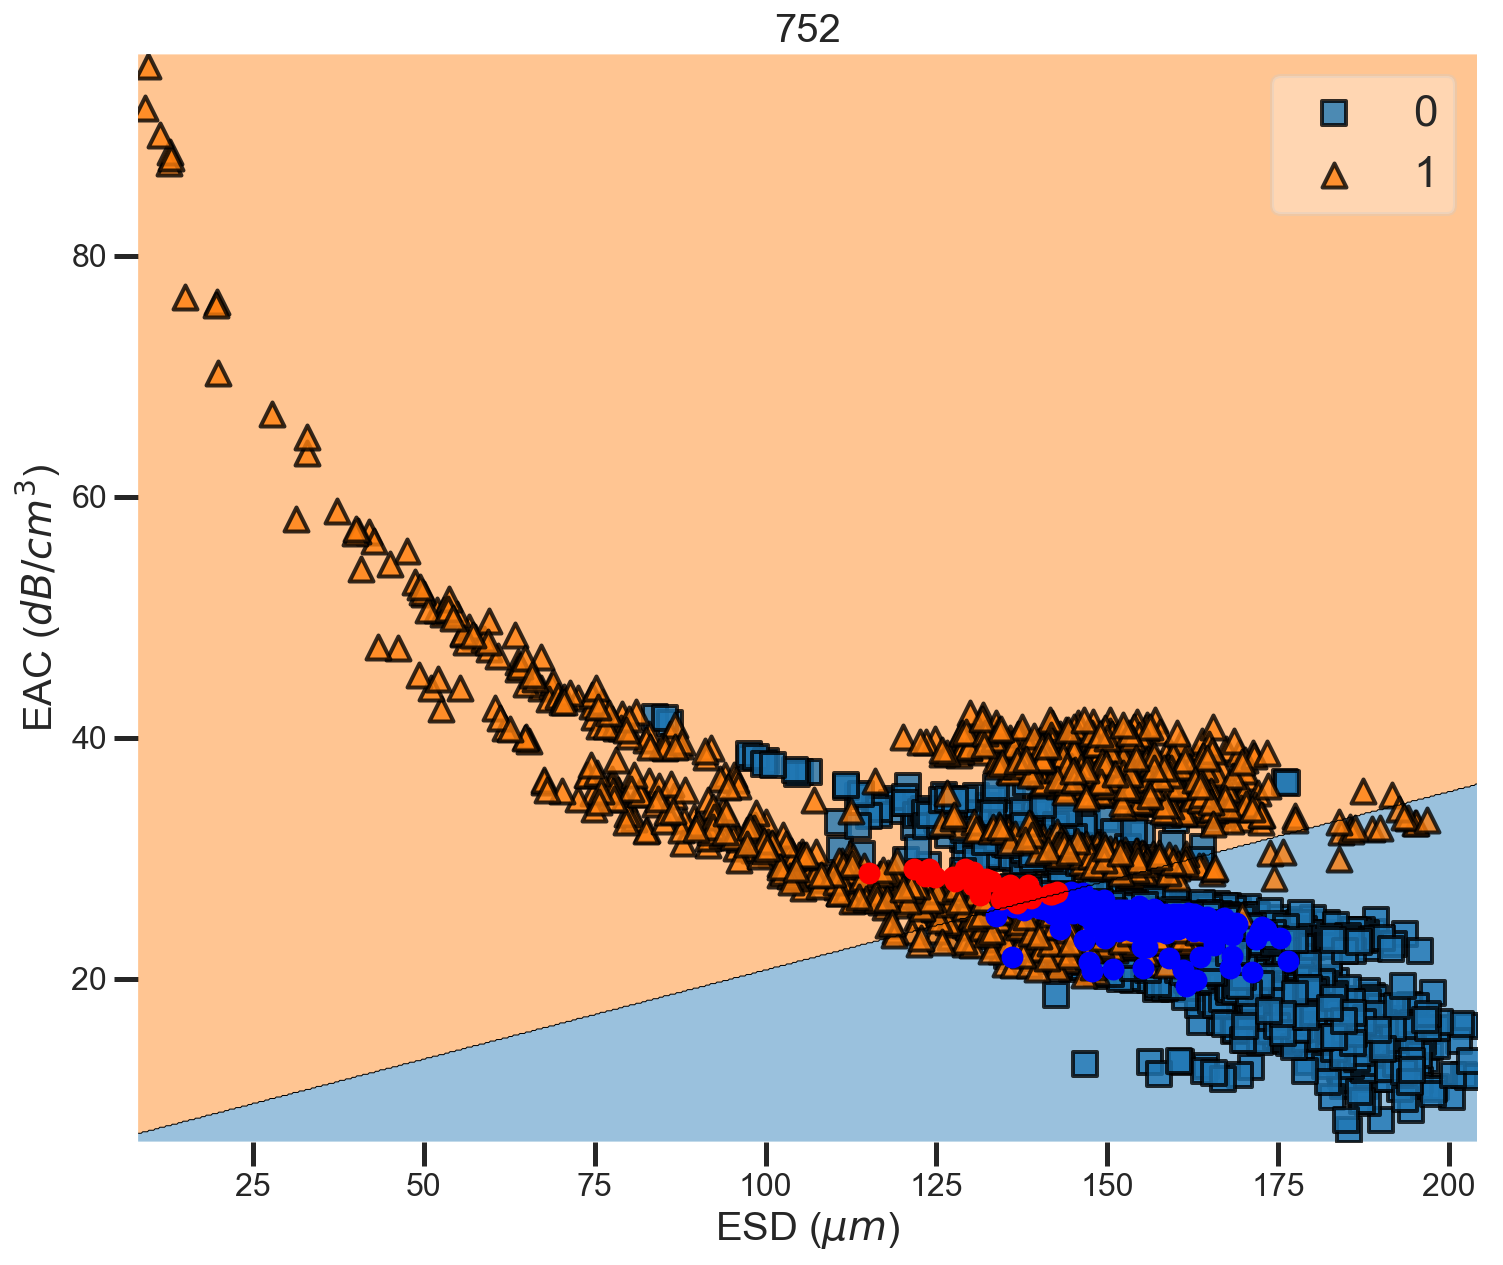

In [16]:
sns.set_style('white')
fig, ax = plt.subplots(1, 1, figsize = (12, 10))
plot_decision_regions(X = features_train, y = y_train.astype(np.integer), clf = clf, ax = ax)
ax.scatter(features_test[l3, 0], features_test[l3, 1], c = 'blue', s = 80)
ax.scatter(features_test[l4, 0], features_test[l4, 1], c = 'red', s = 80)
ax.set_xlabel('ESD ($\mu m$)')
ax.set_ylabel('EAC ($dB/cm^3$)')
plt.title(str(testing_idx[0]))
plt.show()

In [21]:
# 3 components
print("Linear testing | PCA testing | Linear training | PCA training")
print(accuracy_roi_comparison)
print('------')
print(np.mean(accuracy_roi_comparison, axis =0))
print('-------')
print(accuracy_frame_comparison)
print('-------')
print(np.mean(accuracy_frame_comparison, axis =0))

Linear testing | PCA testing | Linear training | PCA training
[[ 0.          0.          0.84660061  0.84557567]
 [ 0.96666667  0.95897436  0.78362134  0.79226146]
 [ 1.          1.          0.80331675  0.80597015]
 [ 0.88259109  0.75708502  0.80606061  0.81604278]
 [ 1.          1.          0.79677862  0.80054832]
 [ 0.89413448  0.83261803  0.78155546  0.79175521]
 [ 0.01515152  0.01515152  0.82652378  0.82886805]
 [ 1.          1.          0.80193721  0.80360721]
 [ 0.04705882  0.09411765  0.83934768  0.84212353]
 [ 0.98850575  0.98850575  0.7989882   0.79797639]
 [ 0.60869565  0.66666667  0.80507893  0.81056966]
 [ 0.05825243  0.12135922  0.84504568  0.84820801]
 [ 1.          1.          0.79884668  0.80122117]
 [ 0.68292683  0.95121951  0.80205912  0.80371969]
 [ 0.          0.          0.81494804  0.81894484]]
------
[ 0.60959888  0.62571318  0.81004725  0.81382614]
-------
[[ 0.          0.          0.          0.        ]
 [ 1.          1.          0.          0.        ]
 [ 1.

In [14]:
from helper_brl.combineFeatures import combine_bscs_atts

In [34]:
lg_accuracy = np.zeros((15,2))
weights_lg = np.zeros((15, 4))
for i in range(no_cv):
    #testing_idx = all_idx[i*no_test_rabbits:i*no_test_rabbits+no_test_rabbits]
    testing_idx = [all_idx[i]]
    print(testing_idx)
    
    X_train, y_train = combine_bscs_atts(dataBase, testing_idx, freq, \
                                         BSCs_dict, ATTs_dict, training = True)

    X_test, y_test = combine_bscs_atts(dataBase, testing_idx, freq, \
                                         BSCs_dict, ATTs_dict, training = False)
    #clf = svm.SVC(C=1.0, kernel='linear', gamma=1) #{'C': 10, 'gamma': 0.1}
    #clf.fit(X_train, y_train)
    clf_lg = LogisticRegression()
    clf_lg.fit(X_train,y_train)
    weights_lg[i, :] = clf_lg.coef_.squeeze()
    #width = 0.35       # the width of the bars: can also be len(x) sequence
    #p1 = plt.bar(np.arange(4) , clf_lg.coef_.squeeze(), width)
    #plt.title('Weights of each features')
    #sup_t = plt.xticks(ind, ('ESD', 'EAC', 'att slope', 'att mid-band fit'))
    #plt.show()
    print('Intercept')
    print(clf_lg.intercept_)
    y_predict_lg = clf_lg.predict(X_test)
    lg_accuracy[i, 0] = accuracy_score(y_test, y_predict_lg)
    lg_accuracy[i, 1] = accuracy_score(y_train, clf_lg.predict(X_train))
    print(lg_accuracy[i, 0], lg_accuracy[i, 1])

[729]
Intercept
[-1.54771346]
0.278481012658 0.894378194208
[749]
Intercept
[-2.20456877]
0.993150684932 0.846253229974
[750]
Intercept
[-2.47580175]
1.0 0.864715626726
[752]
Intercept
[-2.06528766]
0.971563981043 0.860650705955
[730]
Intercept
[-2.44115323]
1.0 0.857226107226
[739]
Intercept
[-1.67966568]
0.919708029197 0.858642407278
[751]
Intercept
[-2.50284437]
0.0277777777778 0.889689578714
[754]
Intercept
[-2.55457138]
1.0 0.864953526517
[753]
Intercept
[-3.38376213]
0.102564102564 0.871737923376
[740]
Intercept
[-3.26544991]
0.862068965517 0.864758698092
[731]
Intercept
[-1.77002923]
0.434210526316 0.8679138322
[755]
Intercept
[-5.46912303]
0.0862068965517 0.896751740139
[757]
Intercept
[-2.50600454]
1.0 0.858371559633
[756]
Intercept
[-2.51706882]
1.0 0.866702937976
[758]
Intercept
[ 3.00198011]
0.492307692308 0.843037974684


In [100]:
np.mean(lg_accuracy, axis = 0)

array([ 0.67786931,  0.86705227])

In [18]:
np.mean(lg_accuracy, axis = 0)

array([ 0.67786931,  0.86705227])

In [38]:
mean_weights = np.mean(weights_lg, axis = 0)

std_weights = np.std(weights_lg, axis = 0)

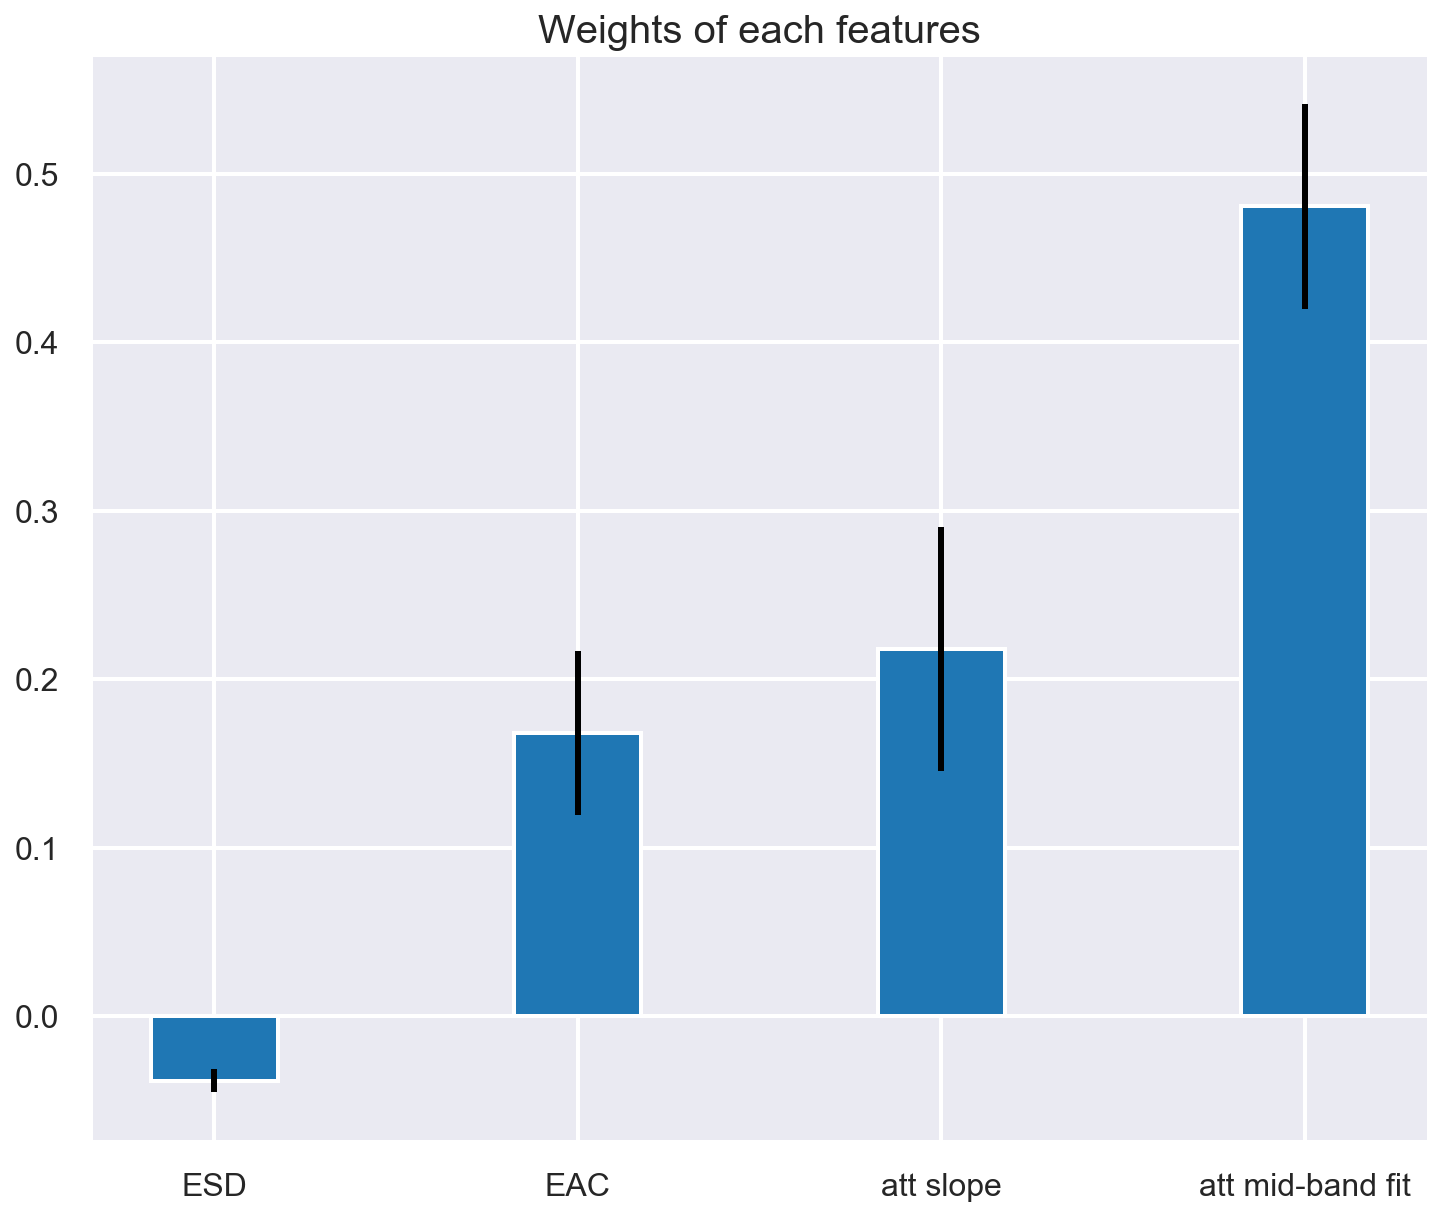

In [45]:
plt.figure(figsize = (12, 10))
width = 0.35       # the width of the bars: can also be len(x) sequence
p1 = plt.bar(np.arange(4) , mean_weights, width, yerr = std_weights)
plt.title('Weights of each features')
sup_t = plt.xticks(ind, ('ESD', 'EAC', 'att slope', 'att mid-band fit'))

In [44]:
weights_lg

array([[-0.05521587,  0.24630519,  0.26664819,  0.47501359],
       [-0.03430398,  0.15783032,  0.17276344,  0.45436657],
       [-0.03688998,  0.17023449,  0.22106893,  0.48306425],
       [-0.03543774,  0.16343778,  0.25193972,  0.43106905],
       [-0.03636357,  0.16540424,  0.23040507,  0.48760954],
       [-0.03267344,  0.12205941,  0.24899918,  0.54507737],
       [-0.04630147,  0.19606841,  0.23830904,  0.65388765],
       [-0.03624303,  0.16926617,  0.22272274,  0.48371236],
       [-0.03454966,  0.19798556,  0.10037718,  0.4334044 ],
       [-0.03101135,  0.15983406,  0.21720222,  0.51186842],
       [-0.03986181,  0.15282816,  0.15521621,  0.49516384],
       [-0.03095995,  0.25011047,  0.09330629,  0.37999995],
       [-0.0364734 ,  0.1692176 ,  0.22029718,  0.48195582],
       [-0.03663303,  0.17030009,  0.21873574,  0.48296138],
       [-0.05040301,  0.03300542,  0.41394355,  0.41369471]])